# AI vs Human Essay Text Classification with Deep Learning

## 1. Import Libraries

### 1.1. Install Additional Libraries (if using Google Colab)

In [1]:
#!pip install torchviz

### 1.2. Import Necessary Librarie

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import os # cross-platform file path handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import string
import math
import time
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import contractions

# Sklearn libraries for machine learning and text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate, validation_curve, learning_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


# NLTK libraries for text processing (lemmatization, stemming, stopwords, POS tagging)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree


# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # WordNet for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('averaged_perceptron_tagger')  # POS tagger for part-of-speech tagging
nltk.download('averaged_perceptron_tagger_eng')  # Additional tagger
nltk.download('tagsets_json')  # Tagset resource

print("\n All libraries imported successfully!")


# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Conv1D,Flatten,Embedding,MaxPool1D,concatenate,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.optimizers import Adam

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm import tqdm


# Logging
import logging
logging.basicConfig(level=logging.INFO)



# Data Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/sang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/sang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[n


 All libraries imported successfully!


### Checking/Setting the Computation Device

In [4]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(device))
print("If you see 'cuda:0', it means GPU is available and will be used")
print("If you see 'cpu', it means only CPU will be used")

Available device: cpu
If you see 'cuda:0', it means GPU is available and will be used
If you see 'cpu', it means only CPU will be used


## 2. Data Overview and Importing

### Reading a text-based dataset into Pandas

In [8]:
df_train = pd.read_csv(os.path.join("..", "data", "AI_vs_huam_train_dataset.csv"))

In [9]:
df_train.head()

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


## 3. Text Pre-processing

In [10]:
def clean_text(text):
  """Basic text cleaning"""
  if not isinstance(text, str):
      return ""

  # Convert to lowercase
  text = text.lower()

  # Remove URLs, emails, HTML tags
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'\S+@\S+', '', text)
  text = re.sub(r'<.*?>', '', text)

  # Remove special characters but keep spaces
  text = re.sub(r"-", " ", text) # Replace dash(es) with single whitespace
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  # Expand contractions
  text = contractions.fix(text)

  # Remove extra whitespace
  text = ' '.join(text.split())

  return text

In [11]:
# Clean text for tokenization with GloVe embedding
df_train["clean_text"] = df_train["essay"].apply(clean_text)

In [12]:
print("--Original--:", df_train["essay"].iloc[0], end="\n\n")
print("--Processed--:", df_train["clean_text"].iloc[0])

--Original--: International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best athletes is vital to develop competitive sports performances in each country.
On the one hand, building specific infrastructure for the best athletes is crucial in order to get better results at international sports events such as The Olympics or the World Cup. The importance of getting better results is that it creates awareness of the importance of sports in society and motivates more people to do a sport. In this way, investing in these developments can help countries to develop an integral sport policy that can benefit everyone.
On the other hand, one can argue that a negative effect could be that less infrastructure is built for the rest of the people. However, people who 

In [13]:
# Define features and target
X = df_train["clean_text"]
y = df_train["label"]

## 4. Create Training & Test Data

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42, stratify=y
)

In [15]:
np.random.seed(7)
torch.manual_seed(7)

# Tokenization
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# Fit tokenizer ONLY on training data
tokenizer.fit_on_texts(X_train)

# Get word index (word to integer mapping)
word_index = tokenizer.word_index

print(f"Found {len(word_index)} unique tokens")

# Show most common words
print("Most frequent words:")
for i, (word, index) in enumerate(list(word_index.items())[:10]):
  print(f"  {i+1}. '{word}': index {index}")

Found 22281 unique tokens
Most frequent words:
  1. 'to': index 1
  2. 'the': index 2
  3. 'and': index 3
  4. 'in': index 4
  5. 'a': index 5
  6. 'of': index 6
  7. 'is': index 7
  8. 'that': index 8
  9. 'people': index 9
  10. 'for': index 10


In [16]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [17]:
for i in range(4):
  print(X_train_seq[i])

[2977, 4, 2, 1716, 22, 83, 159, 5, 624, 8, 7, 1566, 42, 49, 9, 28, 16, 7, 238, 1, 52, 66, 38, 58, 2280, 4, 107, 5, 1792, 289, 44, 229, 214, 2, 156, 8, 18, 625, 58, 22, 5, 1448, 283, 108, 102, 245, 2, 925, 1028, 2, 157, 33, 94, 1, 45, 372, 1329, 58, 15, 2, 53, 126, 1, 17, 440, 38, 21, 2344, 6779, 3, 4525, 102, 39, 16, 7, 53, 2, 115, 2672, 211, 2021, 367, 6, 86, 3, 2, 96, 38, 13, 857, 10, 81, 562, 13, 24, 8, 89, 132, 2281, 625, 361, 16, 7, 1310, 8, 2, 41, 6, 50, 172, 138, 15, 1599, 29, 66, 74, 474, 2344, 39, 29, 66, 16, 7, 1762, 4, 2282, 6, 2, 266, 8, 4898, 138, 15, 415, 5, 360, 407, 4, 2, 686, 6, 5, 1880, 5, 5943, 3, 1717, 1329, 200, 493, 132, 231, 284, 14, 83, 1293, 8, 50, 58, 2344, 8004, 4, 112, 355, 4, 266, 16, 7, 15, 392, 10, 71, 1763, 1, 1029, 18, 474, 1, 2344, 8005, 39, 5, 533, 6, 1448, 6780, 1764, 7, 88, 8, 38, 58, 2402, 68, 16, 270, 1, 2, 196, 289, 16, 7, 46, 8, 5368, 10794, 581, 66, 38, 798, 81, 296, 81, 1600, 3, 87, 81, 10795, 4, 44, 653, 5, 1912, 4526, 21, 17, 416, 222, 2, 96

In [18]:
# Check sequence lengths before padding
lengths = [len(seq) for seq in X_train_seq]
print(f"Average length: {np.mean(lengths):.1f}")
print(f"Max length: {max(lengths)}")
print(f"95th percentile: {np.percentile(lengths, 95):.1f}")

Average length: 282.3
Max length: 407
95th percentile: 366.0


In [19]:
# Padding
X_train_padded = pad_sequences(X_train_seq, maxlen=410, padding="post")
X_val_padded = pad_sequences(X_val_seq, maxlen=410, padding="post")

### Creating Tensors

In [20]:
# Convert input data to LongTensor for embedding lookup
X_train_tensor = torch.LongTensor(X_train_padded)
X_val_tensor = torch.LongTensor(X_val_padded)

y_train_tensor = torch.LongTensor(y_train.values)
y_val_tensor = torch.LongTensor(y_val.values)

### Creating Data Loaders

In [21]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
x_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for X_batch, y_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")

X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410])
y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 410

## 6. Representing Text as Numerical Data using Different Word Embeddings

### 6.1. Download GloVe Embeddings

In [23]:
# Download Embeddings from huggingface

if not os.path.exists("glove.6B.zip"):
  !wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

if not "glove.6B.50d.txt" in os.listdir():
  !unzip glove.6B.zip

### 6.2. Load GloVe Embeddings

In [24]:
embedding_dict = {}
pretrain = open("glove.6B.50d.txt", encoding="utf8")
for i in pretrain:
  value = i.split(" ")
  word = value[0]
  vector = np.array(value[1:])
  embedding_dict[word] = vector

pretrain.close()

print(f"GloVe embeddings loaded: {len(embedding_dict)} words")

GloVe embeddings loaded: 400001 words


### 6.3. Building the Embedding Matrix

Numpy Save Reference: https://numpy.org/doc/2.1/reference/generated/numpy.save.html

In [25]:
emb_matrix = np.zeros( (len(tokenizer.word_index)+1, 50) )

with open("emb_matrix.npy", "wb") as file:
  np.save(file, emb_matrix)

words_found = 0
uncovered_words = []

for word, i in tokenizer.word_index.items():
  emb_word = embedding_dict.get(word)
  if emb_word is not None:
    emb_matrix[i] = emb_word
    words_found += 1
  else:
    uncovered_words.append(word)

coverage_percentage = (words_found / len(tokenizer.word_index)) * 100

print(f"Embedding matrix created:")
print(f"Matrix shape: {emb_matrix.shape}")
print(f"Words found in GloVe: {words_found:,} / {len(tokenizer.word_index):,}")
print(f"Coverage: {coverage_percentage:.2f}%")

# Show uncovered words
if uncovered_words:
  print(f"Sample uncovered words: {uncovered_words[:10]}")

Embedding matrix created:
Matrix shape: (22282, 50)
Words found in GloVe: 13,886 / 22,281
Coverage: 62.32%
Sample uncovered words: ['successfull', 'succed', 'heshe', 'succesfull', 'bussiness', 'covid', 'hisher', 'successed', 'becouse', 'beeing']


In [26]:
emb_matrix.shape

(22282, 50)

### 6.4. Create Embedding Layer

In [27]:
len(tokenizer.index_word)

22281

In [28]:
# Create embedding layer
embedding_layer = Embedding(
    len(tokenizer.word_index)+1,
    50,
    embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
    trainable=False
)

In [29]:
# Summary
print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"Final training data shape: {X_train_padded.shape}")
print(f"Final validation data shape: {X_val_padded.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index):,}")
print(f"Embedding matrix shape: {emb_matrix.shape}")
print(f"Sequence length: {X_train_padded.shape[1]}")
print("Ready for model training!")


PREPROCESSING SUMMARY
Final training data shape: (2982, 410)
Final validation data shape: (746, 410)
Vocabulary size: 22,281
Embedding matrix shape: (22282, 50)
Sequence length: 410
Ready for model training!


## 7. Deep Learning Model Training and Testing

In [30]:
# Create class to store model statistics and training & evaluation methods
class Model:
  def __init__(self, model, *, num_epochs=10, learning_rate=0.001, weight_decay=1e-4, optim="adam", momentum=0):
    self.model = model

    if optim == "adam":
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optim == "sgd":
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    self.criterion = nn.NLLLoss() #nn.CrossEntropyLoss()
    self.epochs = num_epochs

  def evaluate(self, loader):
    model = self.model

    # Set model to "eval" mode
    model.eval()
    model.to(device)

    with torch.no_grad():
      # Collect predictions and ground truth for all samples across all batches
      y_pred, y_test = [], []

      with tqdm(total=len(loader)) as pbar:
        for X_batch, y_batch in loader:
          # Loop over each batch in the data loader
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)

          # Push batch through network to get log probabilities for each sample in batch
          log_probs = model(X_batch)

          # The predicted labels are the index of the highest log probability (for each sample)
          y_batch_pred = torch.argmax(log_probs, dim=1)

          # Add predictiosn and ground truth for current batch
          y_test += list(y_batch.detach().cpu().numpy())
          y_pred += list(y_batch_pred.detach().cpu().numpy())

          pbar.update(1)

    # Set model to "train" mode
    model.train()

    # Return the f1 score as the output result
    return metrics.f1_score(y_test, y_pred, average="micro")

  def train(self, loader_train, loader_test):
    model = self.model

    self.losses = []
    self.f1_train = []
    self.f1_test = []

    # Set model to "train" mode
    model.train()
    model.to(device)

    # Run all epochs
    for epoch in range(1, self.epochs+1):
      # Initialize epoch loss (cumlative loss for all batches)
      epoch_loss = 0.0

      # Calculate loss
      with tqdm(total=len(loader_train)) as pbar:
        # Loop over each batch in the data loader
        for X_batch, y_batch in loader_train:
          # Move data to device
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)

          # Push batch through netework to get log probabilities for each sample in batch
          log_probs = model(X_batch)

          # Calculate loss
          loss = self.criterion(log_probs, y_batch)

          ### PyTorch Magic ###
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # Keep track of overall epoch loss
          epoch_loss += loss.item()

          pbar.update(1)

      # Keep track of all epoch losses
      self.losses.append(epoch_loss)

      # Compute f1 score for both TRAINING and TEST data
      f1_tr = self.evaluate(loader_train)
      f1_te = self.evaluate(loader_test)
      self.f1_train.append(f1_tr)
      self.f1_test.append(f1_te)

      print(f"Loss:\t{epoch_loss:.3f}, f1 train: {f1_tr:.3f}, f1 test: {f1_te:.3f} (epoch {epoch})")

    #return losses, f1_train, f1_test

  def plot_loss(self):
    # Create epoch range
    x = list(range(1, len(self.losses)+1))

    # Convert losses to numpy array
    losses = np.asarray(self.losses)
    # Normalize losses so they match the scale in the plot (we are only interested in the trend of the losses!)
    losses = losses/np.max(losses)

    # Convert F1 scores to numpy arrays (in case they're lists)
    f1_train = np.asarray(self.f1_train)
    f1_test = np.asarray(self.f1_test)

    plt.figure(figsize=(10, 6))

    # Plot all metrics
    plt.plot(x, losses, lw=3, marker='o', markersize=6)
    plt.plot(x, f1_train, lw=3, marker='s', markersize=6)
    plt.plot(x, f1_test, lw=3, marker='^', markersize=6)

    # Font settings
    font_axes = {'family':'serif','color':'black','size':16}

    # Set x-axis ticks to show all epochs
    plt.gca().set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Labels and legend
    plt.xlabel("Epoch", fontdict=font_axes)
    plt.ylabel("Score (Normalized Loss & F1 Score)", fontdict=font_axes)
    plt.legend(['Normalized Loss', 'F1 (train)', 'F1 (validation)'], loc='best', fontsize=14)

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Set y-axis limits for better visualization
    plt.ylim(0, 1.1)

    # Title
    plt.title("Training Progress: Loss and F1 Scores", fontdict=font_axes)

    plt.tight_layout()
    plt.show()

    # Print final results
    print(f"\nFinal Results after {len(losses)} epochs:")
    print(f"Training F1 Score: {f1_train[-1]:.3f}")
    print(f"Validation F1 Score: {f1_test[-1]:.3f}")
    print(f"Final Normalized Loss: {losses[-1]:.3f}")

### 7.1. Convolutionary Neural Network

References:

* https://www.datacamp.com/tutorial/pytorch-cnn-tutorial

Overfitting References:

* https://stackoverflow.com/questions/59003591/how-to-implement-dropout-in-pytorch-and-where-to-apply-it
* https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html
* https://www.kaggle.com/code/ouardasakram/cnn-with-pytorch-resnet-regularization#Convolution-Neural-Network

In [31]:
class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, sequence_length):
    super().__init__()

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
    self.embedding.weight.requires_grad = False # False = Freeze embeddings

    # Sequential Convolutional layers
    self.net = nn.Sequential(
        nn.Conv1d(embedding_dim, 64, 5),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(2, 2),
        nn.Dropout1d(0.5),

        nn.Conv1d(64, 128, 5),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(2, 2),
        nn.Dropout1d(0.5),

        nn.Flatten(),

        nn.Linear(128 * 99, 64),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(32, 2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, X):
    # X should be LongTensor (token indices)
    embedded = self.embedding(X)

    #### Gemini Suggestions ####
    # Permute the dimensions to be (batch_size, embedding_dim, sequence_length)
    embedded = embedded.permute(0, 2, 1)
    ############################

    out = self.net(embedded)
    return out

### 7.2. Recurrent Neural Network

References:

* https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
* https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/
* https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch
* https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525

In [32]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, sequence_length, *, hidden_size=128, num_layers=1, bidirectional=False):
    super().__init__()

    self.hidden_size = hidden_size
    self.layers = num_layers
    self.direction = 2 if bidirectional else 1

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
    self.embedding.weight.requires_grad = False # False = Freeze embeddings

    # RNN layer
    self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=bidirectional)

    # Sequential layer
    self.net = nn.Sequential(
        nn.Dropout(0.3),

        nn.Linear(hidden_size * self.direction, 32),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(16, 2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, X):
    embedded = self.embedding(X)

    h0 = torch.zeros(self.layers * self.direction, embedded.size(0), self.hidden_size).to(device)
    out, hidden = self.rnn(embedded, h0)

    pooled = out.mean(dim=1)
    log_probs = self.net(pooled)
    return log_probs

### 7.3. Long Short-Term Memory (LSTM)

References:

* https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/
* https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
* https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5
* https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525

In [33]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, sequence_length, *, hidden_size=128, num_layers=1, bidirectional=False):
    super().__init__()

    self.hidden_size = hidden_size
    self.layers = num_layers
    self.direction = 2 if bidirectional else 1

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
    self.embedding.weight.requires_grad = False # Freeze embeddings

    # LSTM layer
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=bidirectional)

    # Sequential layer
    self.net = nn.Sequential(
        nn.Dropout(0.3),

        nn.Linear(self.hidden_size * self.direction, 32),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(16, 2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, X):
    embedded = self.embedding(X)

    h0 = torch.zeros(self.layers * self.direction, embedded.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.layers * self.direction, embedded.size(0), self.hidden_size).to(device)
    out, (hidden, cell) = self.lstm(embedded, (h0, c0))

    pooled = out.mean(dim=1)
    log_probs = self.net(pooled)
    return log_probs

Reference for very low `learning_rate` for RNN model:

* https://stackoverflow.com/questions/39309388/keras-rnn-loss-does-not-decrease-over-epoch

In [34]:
# Neural Network Model Settings
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
sequence_length = 420
hidden_size = 32   # For RNN model

cnn_model = Model(CNN(vocab_size, embedding_dim, sequence_length),
                  num_epochs=20, learning_rate=1e-4, weight_decay=1e-5)

rnn_model = Model(RNN(vocab_size, embedding_dim, sequence_length, hidden_size=hidden_size, num_layers=3, bidirectional=True),
                  num_epochs=20, learning_rate=3e-4, weight_decay=1e-5)

lstm_model = Model(LSTM(vocab_size, embedding_dim, sequence_length, hidden_size=hidden_size, num_layers=3, bidirectional=True),
                   num_epochs=20, learning_rate=3e-4, weight_decay=1e-5)

### 7.4. Training & Evaluating the Model

#### 7.4.1. Evaluation

In [35]:
# Evaluate the CNN model
cnn_model.evaluate(x_val_loader)

100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 138.48it/s]


0.5

In [36]:
# Evaluate the RNN model
rnn_model.evaluate(x_val_loader)

100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.60it/s]


0.5

In [37]:
# Evaluate the LSTM model
lstm_model.evaluate(x_val_loader)

100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.88it/s]


0.5

#### 7.4.2. Training (and evaluation after each epoch)

In [38]:
# Train the CNN model
cnn_model.train(train_loader, x_val_loader)

100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 188.16it/s]


Loss:	63.348, f1 train: 0.653, f1 test: 0.637 (epoch 1)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 187.74it/s]


Loss:	61.503, f1 train: 0.679, f1 test: 0.649 (epoch 2)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 175.58it/s]


Loss:	59.700, f1 train: 0.696, f1 test: 0.658 (epoch 3)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 184.10it/s]


Loss:	58.779, f1 train: 0.708, f1 test: 0.668 (epoch 4)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 150.78it/s]


Loss:	56.482, f1 train: 0.725, f1 test: 0.684 (epoch 5)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 189.30it/s]


Loss:	56.984, f1 train: 0.751, f1 test: 0.706 (epoch 6)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 194.43it/s]


Loss:	55.327, f1 train: 0.780, f1 test: 0.747 (epoch 7)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 151.00it/s]


Loss:	53.547, f1 train: 0.799, f1 test: 0.765 (epoch 8)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 187.23it/s]


Loss:	50.728, f1 train: 0.835, f1 test: 0.800 (epoch 9)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 179.14it/s]


Loss:	49.187, f1 train: 0.843, f1 test: 0.808 (epoch 10)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 188.71it/s]


Loss:	46.139, f1 train: 0.849, f1 test: 0.815 (epoch 11)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 182.85it/s]


Loss:	42.330, f1 train: 0.866, f1 test: 0.823 (epoch 12)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 157.80it/s]


Loss:	41.694, f1 train: 0.869, f1 test: 0.827 (epoch 13)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 154.16it/s]


Loss:	41.172, f1 train: 0.872, f1 test: 0.826 (epoch 14)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 182.58it/s]


Loss:	38.809, f1 train: 0.879, f1 test: 0.839 (epoch 15)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 184.47it/s]


Loss:	38.079, f1 train: 0.873, f1 test: 0.826 (epoch 16)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 183.31it/s]


Loss:	37.938, f1 train: 0.841, f1 test: 0.807 (epoch 17)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 162.77it/s]


Loss:	34.468, f1 train: 0.897, f1 test: 0.846 (epoch 18)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 172.42it/s]


Loss:	34.183, f1 train: 0.877, f1 test: 0.820 (epoch 19)


100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 178.09it/s]

Loss:	35.822, f1 train: 0.902, f1 test: 0.845 (epoch 20)


In [39]:
# Train the RNN model
rnn_model.train(train_loader, x_val_loader)

100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.48it/s]


Loss:	65.150, f1 train: 0.523, f1 test: 0.544 (epoch 1)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.92it/s]


Loss:	57.169, f1 train: 0.797, f1 test: 0.775 (epoch 2)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.92it/s]


Loss:	45.089, f1 train: 0.816, f1 test: 0.791 (epoch 3)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.64it/s]


Loss:	41.183, f1 train: 0.822, f1 test: 0.796 (epoch 4)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.77it/s]


Loss:	39.640, f1 train: 0.793, f1 test: 0.784 (epoch 5)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.80it/s]


Loss:	39.649, f1 train: 0.834, f1 test: 0.806 (epoch 6)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.70it/s]


Loss:	37.505, f1 train: 0.826, f1 test: 0.798 (epoch 7)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.36it/s]


Loss:	36.933, f1 train: 0.846, f1 test: 0.811 (epoch 8)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.97it/s]


Loss:	37.418, f1 train: 0.816, f1 test: 0.790 (epoch 9)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.00it/s]


Loss:	36.852, f1 train: 0.848, f1 test: 0.820 (epoch 10)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.05it/s]


Loss:	35.482, f1 train: 0.850, f1 test: 0.818 (epoch 11)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.19it/s]


Loss:	35.860, f1 train: 0.839, f1 test: 0.818 (epoch 12)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.56it/s]


Loss:	35.312, f1 train: 0.843, f1 test: 0.814 (epoch 13)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.64it/s]


Loss:	33.563, f1 train: 0.847, f1 test: 0.826 (epoch 14)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.43it/s]


Loss:	34.934, f1 train: 0.864, f1 test: 0.838 (epoch 15)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.04it/s]


Loss:	34.646, f1 train: 0.870, f1 test: 0.847 (epoch 16)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.44it/s]


Loss:	34.975, f1 train: 0.865, f1 test: 0.840 (epoch 17)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.67it/s]


Loss:	32.543, f1 train: 0.866, f1 test: 0.847 (epoch 18)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.99it/s]


Loss:	31.284, f1 train: 0.868, f1 test: 0.857 (epoch 19)


100%|████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.73it/s]

Loss:	32.340, f1 train: 0.857, f1 test: 0.850 (epoch 20)


In [40]:
# Train the LSTM model
lstm_model.train(train_loader, x_val_loader)

100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.49it/s]


Loss:	65.257, f1 train: 0.500, f1 test: 0.500 (epoch 1)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.11it/s]


Loss:	63.383, f1 train: 0.782, f1 test: 0.782 (epoch 2)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.86it/s]


Loss:	48.516, f1 train: 0.800, f1 test: 0.792 (epoch 3)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.37it/s]


Loss:	41.239, f1 train: 0.838, f1 test: 0.816 (epoch 4)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.49it/s]


Loss:	37.114, f1 train: 0.846, f1 test: 0.824 (epoch 5)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.43it/s]


Loss:	35.832, f1 train: 0.860, f1 test: 0.830 (epoch 6)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.17it/s]


Loss:	35.501, f1 train: 0.865, f1 test: 0.849 (epoch 7)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.27it/s]


Loss:	33.522, f1 train: 0.856, f1 test: 0.842 (epoch 8)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.55it/s]


Loss:	32.200, f1 train: 0.882, f1 test: 0.863 (epoch 9)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.13it/s]


Loss:	30.719, f1 train: 0.887, f1 test: 0.870 (epoch 10)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.93it/s]


Loss:	28.275, f1 train: 0.895, f1 test: 0.882 (epoch 11)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.03it/s]


Loss:	27.536, f1 train: 0.868, f1 test: 0.834 (epoch 12)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.54it/s]


Loss:	27.803, f1 train: 0.906, f1 test: 0.895 (epoch 13)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.26it/s]


Loss:	27.783, f1 train: 0.908, f1 test: 0.890 (epoch 14)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.12it/s]


Loss:	25.704, f1 train: 0.890, f1 test: 0.883 (epoch 15)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.56it/s]


Loss:	24.419, f1 train: 0.887, f1 test: 0.866 (epoch 16)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.44it/s]


Loss:	25.936, f1 train: 0.907, f1 test: 0.897 (epoch 17)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.31it/s]


Loss:	22.552, f1 train: 0.911, f1 test: 0.905 (epoch 18)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.93it/s]


Loss:	20.428, f1 train: 0.916, f1 test: 0.908 (epoch 19)


100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 36.64it/s]

Loss:	20.170, f1 train: 0.932, f1 test: 0.905 (epoch 20)


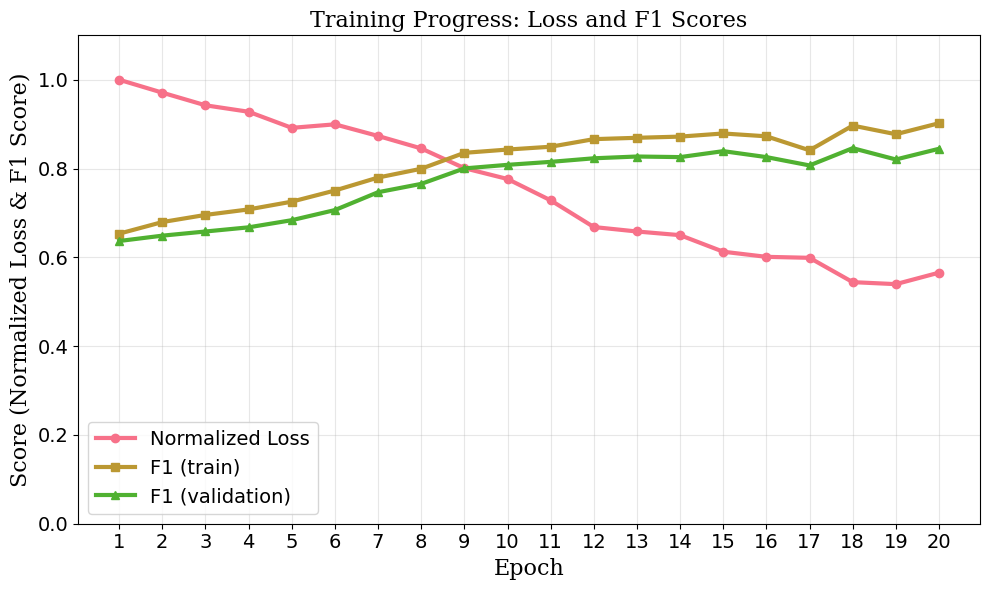


Final Results after 20 epochs:
Training F1 Score: 0.902
Validation F1 Score: 0.845
Final Normalized Loss: 0.565


In [41]:
# Plot CNN losses
cnn_model.plot_loss()

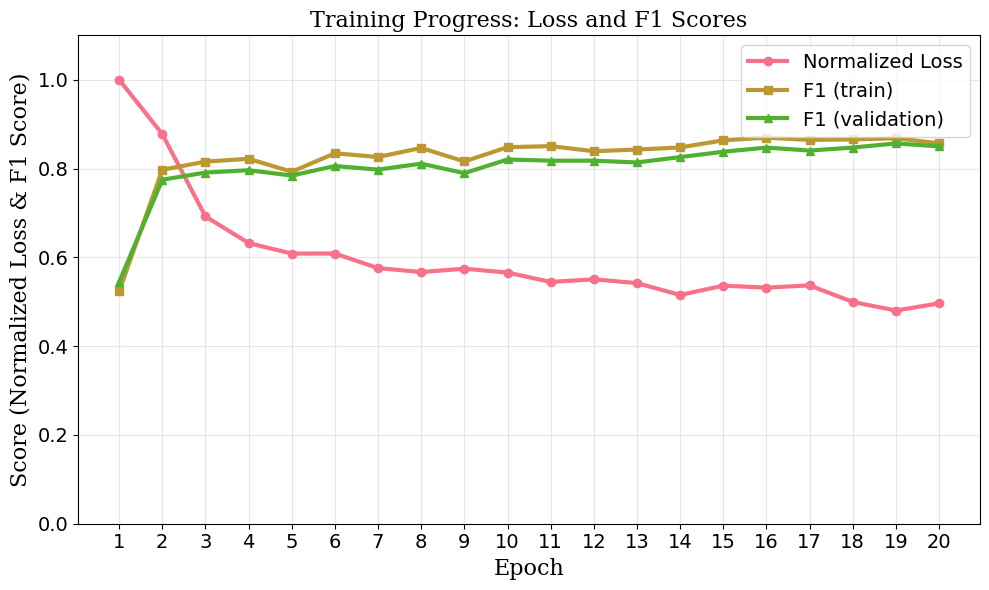


Final Results after 20 epochs:
Training F1 Score: 0.857
Validation F1 Score: 0.850
Final Normalized Loss: 0.496


In [42]:
# Plot RNN losses
rnn_model.plot_loss()

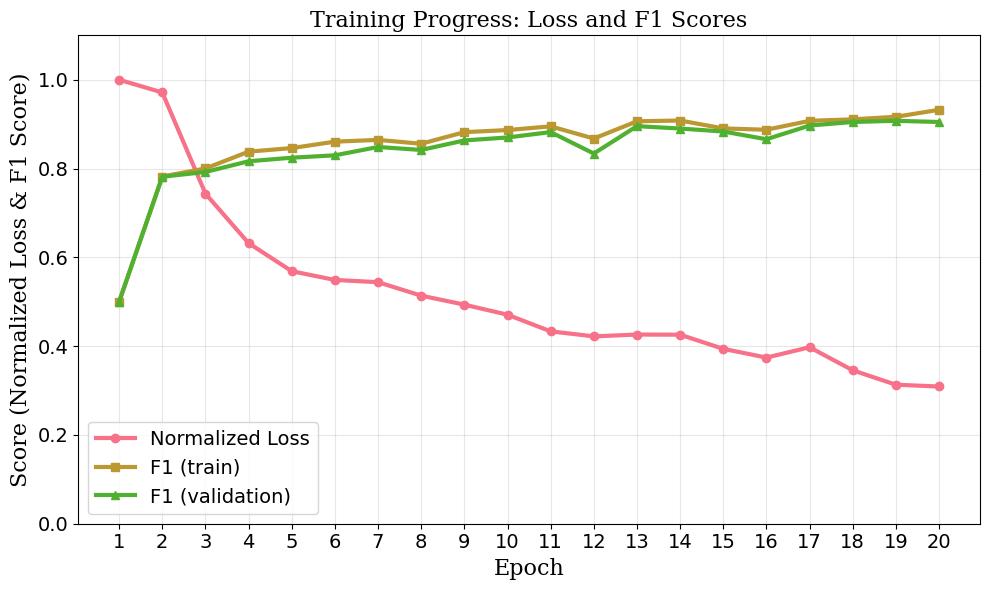


Final Results after 20 epochs:
Training F1 Score: 0.932
Validation F1 Score: 0.905
Final Normalized Loss: 0.309


In [43]:
# Plot LSTM losses
lstm_model.plot_loss()

## 8. Saving the Models

References:

* https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html

In [44]:
# Path variables for saving models
MODELS_PATH = os.path.join("..", "models")

cnn_path = os.path.join(MODELS_PATH, "CNN.pkl")
rnn_path = os.path.join(MODELS_PATH, "RNN.pkl")
lstm_path = os.path.join(MODELS_PATH, "LSTM.pkl")

### 8.1. CNN

In [122]:
torch.save(cnn_model.model, cnn_path)

### 8.1. RNN

In [123]:
torch.save(rnn_model.model, rnn_path)

### 8.2. LSTM

In [124]:
torch.save(lstm_model.model, lstm_path)